# Agentic system for image generation - inpainting

## Path setting

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
module_path = "../.."
sys.path.append(os.path.abspath(module_path))

## 1. Create Bedrock client

In [3]:
from pprint import pprint
from termcolor import colored
from utils import bedrock
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [4]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: None
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-5-Sonnet': 'anthropic.claude-3-5-sonnet-20240620-v1:0',
 'Claude-V3-5-V-2-Sonnet': 'anthropic.claude-3-5-sonnet-20241022-v2:0',
 'Claude-V3-5-V-2-Sonnet-CRI': 'us.anthropic.claude-3-5-sonnet-20241022-v2:0',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Opus': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid

## 2. LLM 정의

In [5]:
from utils.bedrock import bedrock_model
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [6]:
llm = bedrock_model(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-5-V-2-Sonnet-CRI"),
    #model_id=bedrock_info.get_model_id(model_name="Claude-V3-5-Sonnet"),
    #model_id=bedrock_info.get_model_id(model_name="Nova-Pro-CRI"),
    bedrock_client=boto3_bedrock,
    stream=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    inference_config={
        'maxTokens': 1024,
        'stopSequences': ["\n\nHuman"],
        'temperature': 0.01,
        #'topP': ...,
    }
    #additional_model_request_fields={"top_k": 200}
)

In [7]:
image_generation_model = bedrock_model(
    model_id=bedrock_info.get_model_id(model_name="Nova-Canvas"),
    bedrock_client=boto3_bedrock
)

## 3. Masking images
### 3.1 Get masking imges from online app.
- Go to [Inpaint-mask-maker](https://huggingface.co/spaces/stevhliu/inpaint-mask-maker)
    - Upload image
    - Select masking area by your mouse
    - Download masking image (webp format) and `upload` it to `masking` folder
![nn](./imgs/inpainting/masking_samples.png)

### 3.2 Preprcessing for masking images

In [8]:
import os
from PIL import Image, ImageOps

In [9]:
def webp_to_png_with_inverse(input_path, output_path=None):
    """
    WebP 이미지를 PNG로 변환하고 inverse masking된 이미지도 함께 생성하는 함수
    
    Args:
        input_path (str): WebP 파일 경로
        output_path (str, optional): 저장할 PNG 파일 경로. 
                                   None인 경우 원본 파일명에 .png 확장자 사용
    Returns:
        tuple: (일반 변환 이미지 경로, inverse 이미지 경로)
    """
    try:
        # 이미지 열기
        img = Image.open(input_path)
        
        # output_path가 지정되지 않은 경우 원본 파일명 사용
        if output_path is None:
            file_name = os.path.splitext(input_path)[0]
            output_path = file_name + '.png'
            inverse_output_path = file_name + '_inverse.png'
        else:
            # output_path가 지정된 경우, inverse 이미지 경로 생성
            file_name = os.path.splitext(output_path)[0]
            inverse_output_path = file_name + '_inverse.png'
        
        # 원본 이미지 PNG로 저장
        img.save(output_path, 'PNG')
        
        # Inverse masking 적용
        if img.mode == 'RGBA':
            # RGBA 이미지의 경우 알파 채널 보존
            r, g, b, a = img.split()
            rgb_img = Image.merge('RGB', (r, g, b))
            inverse_img = ImageOps.invert(rgb_img)
            inverse_img.putalpha(a)
        else:
            # RGB 또는 다른 모드의 이미지
            inverse_img = ImageOps.invert(img)
        
        # Inverse 이미지 저장
        inverse_img.save(inverse_output_path, 'PNG')
        
        print(f'일반 변환 완료: {output_path}')
        print(f'Inverse 변환 완료: {inverse_output_path}')
        
        return output_path, inverse_output_path
        
    except Exception as e:
        print(f'변환 중 오류 발생: {str(e)}')
        return None, None

def convert_folder_with_inverse(folder_path):
    """
    폴더 내의 모든 WebP 파일을 PNG로 변환하고 inverse 이미지도 생성
    
    Args:
        folder_path (str): WebP 파일들이 있는 폴더 경로
    """
    converted_files = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith('.webp'):
            input_path = os.path.join(folder_path, filename)
            normal_path, inverse_path = webp_to_png_with_inverse(input_path)
            if normal_path and inverse_path:
                converted_files.append((normal_path, inverse_path))
    
    return converted_files

In [10]:
# 단일 파일 변환
normal_path, inverse_path = webp_to_png_with_inverse(
    input_path="./sample_images/masking_image.webp"
)

# 특정 폴더의 모든 파일 변환
#converted_files = convert_folder_with_inverse('images_folder')

일반 변환 완료: ./sample_images/masking_image.png
Inverse 변환 완료: ./sample_images/masking_image_inverse.png


## 4. Inpainitng examples

In [11]:
import io
import json
import base64
import random
import matplotlib.pyplot as plt

In [12]:
def _png_to_bytes(file_path):
    try:
        with open(file_path, "rb") as image_file:
            # 파일을 바이너리 모드로 읽기
            binary_data = image_file.read()

            # 바이너리 데이터를 base64로 인코딩
            base64_encoded = base64.b64encode(binary_data)

            # bytes 타입을 문자열로 디코딩
            base64_string = base64_encoded.decode('utf-8')

            return binary_data, base64_string

    except FileNotFoundError:
        return "Error: 파일을 찾을 수 없습니다."
    except Exception as e:
        return f"Error: {str(e)}"

def _img_generation_and_show(image_generation_model, body, original_image_path, mask_image_path=None):
    # 원본 이미지 로드
    original_image = Image.open(original_image_path)
    
    # 생성된 이미지 얻기
    response = image_generation_model.bedrock_client.invoke_model(
        body=body,
        modelId=image_generation_model.model_id
    )
    response_body = json.loads(response.get("body").read())
    base64_image = response_body.get("images")[0]
    image_data = base64.b64decode(base64_image)
    generated_image = Image.open(io.BytesIO(image_data))
    
    # mask_image_path의 유무에 따라 subplot 개수 조정
    if mask_image_path:
        # 마스크 이미지가 있는 경우 3개의 subplot 생성
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
        
        # 원본 이미지 표시
        ax1.imshow(original_image)
        ax1.axis('off')
        ax1.set_title('Original Image')
        
        # 마스크 이미지 표시
        mask_image = Image.open(mask_image_path)
        ax2.imshow(mask_image)
        ax2.axis('off')
        ax2.set_title('Mask Image')
        
        # 생성된 이미지 표시
        ax3.imshow(generated_image)
        ax3.axis('off')
        ax3.set_title('Generated Image')
    else:
        # 마스크 이미지가 없는 경우 2개의 subplot 생성
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
        
        # 원본 이미지 표시
        ax1.imshow(original_image)
        ax1.axis('off')
        ax1.set_title('Original Image')
        
        # 생성된 이미지 표시
        ax2.imshow(generated_image)
        ax2.axis('off')
        ax2.set_title('Generated Image')
    
    plt.tight_layout()  # 레이아웃 조정
    plt.show()


### Case 1: 인물 교체 (주위 환경 고정)

In [13]:
origin_img_path = "./sample_images/GENERATED_IMAGE.png"
origin_img_bytes, origin_img_base64 = _png_to_bytes(origin_img_path)

mask_img_path = "./sample_images/skin_masking_image_inverse.png"
mask_img_bytes, mask_img_base64 = _png_to_bytes(mask_img_path)

In [14]:
body = json.dumps(
    {
        "taskType": "INPAINTING",
        "inPaintingParams": {
            "text": "African village man, ultra high-resolution 8K output with sharp details",
            "negativeText": "bad quality, low res",
            "image": origin_img_base64,
            "maskImage": mask_img_base64
            #"maskPrompt": "washing machine"
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,
            "height": 512,
            "width": 512,
            "cfgScale": 9,
            "seed": 10
            
        }
    }
)

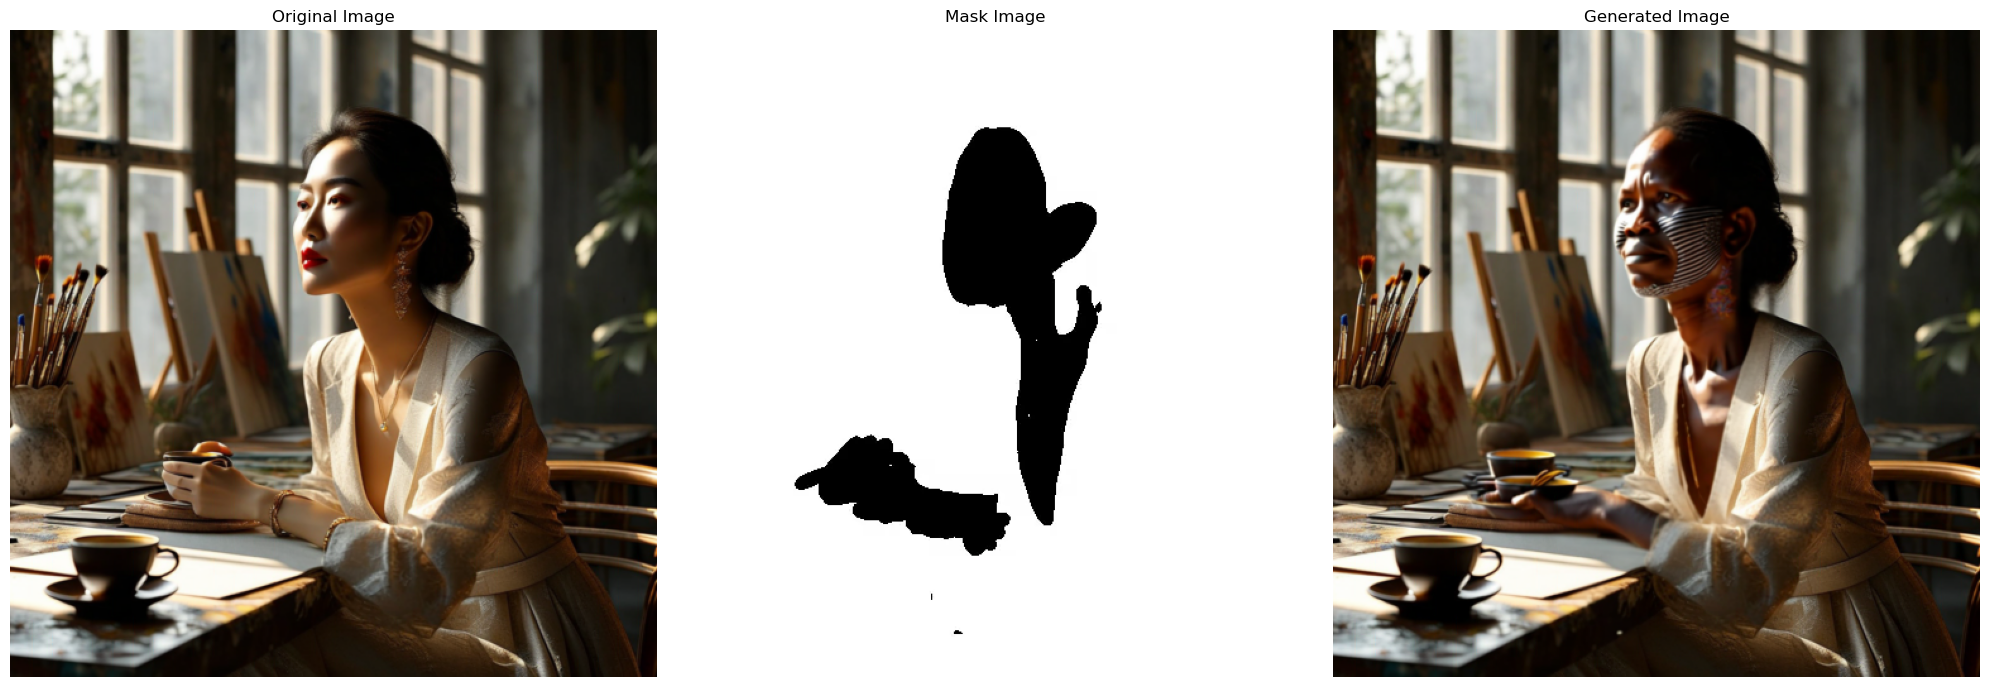

In [15]:
_img_generation_and_show(
    image_generation_model=image_generation_model,
    body=body,
    original_image_path=origin_img_path,
    mask_image_path=mask_img_path
)

### Case 2: 의상 교체 (인물 고정)

In [16]:
origin_img_path = "./sample_images/GENERATED_IMAGE.png"
origin_img_bytes, origin_img_base64 = _png_to_bytes(origin_img_path)

mask_img_path = "./sample_images/cloth_masking_image_inverse.png"
mask_img_bytes, mask_img_base64 = _png_to_bytes(mask_img_path)

In [17]:
body = json.dumps(
    {
        "taskType": "INPAINTING",
        "inPaintingParams": {
            "text": "a woman wearing a luxurious traditional Korean hanbok, ivory-colored jeogori (upper garment) with delicate embroidery details, subtle silk texture, elegant neckline with white goreum (ribbon-like tie), high-quality fabric with natural sheen, graceful draping, modern feminine hanbok style, studio lighting from window, soft natural sunlight, ultra high-resolution 8K output with sharp details",
            "negativeText": "bad quality, low res",
            "image": origin_img_base64,
            "maskImage": mask_img_base64
            #"maskPrompt": "washing machine"
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,
            "height": 512,
            "width": 512,
            "cfgScale": 9.0,
            "seed": 10
            
        }
    }
)

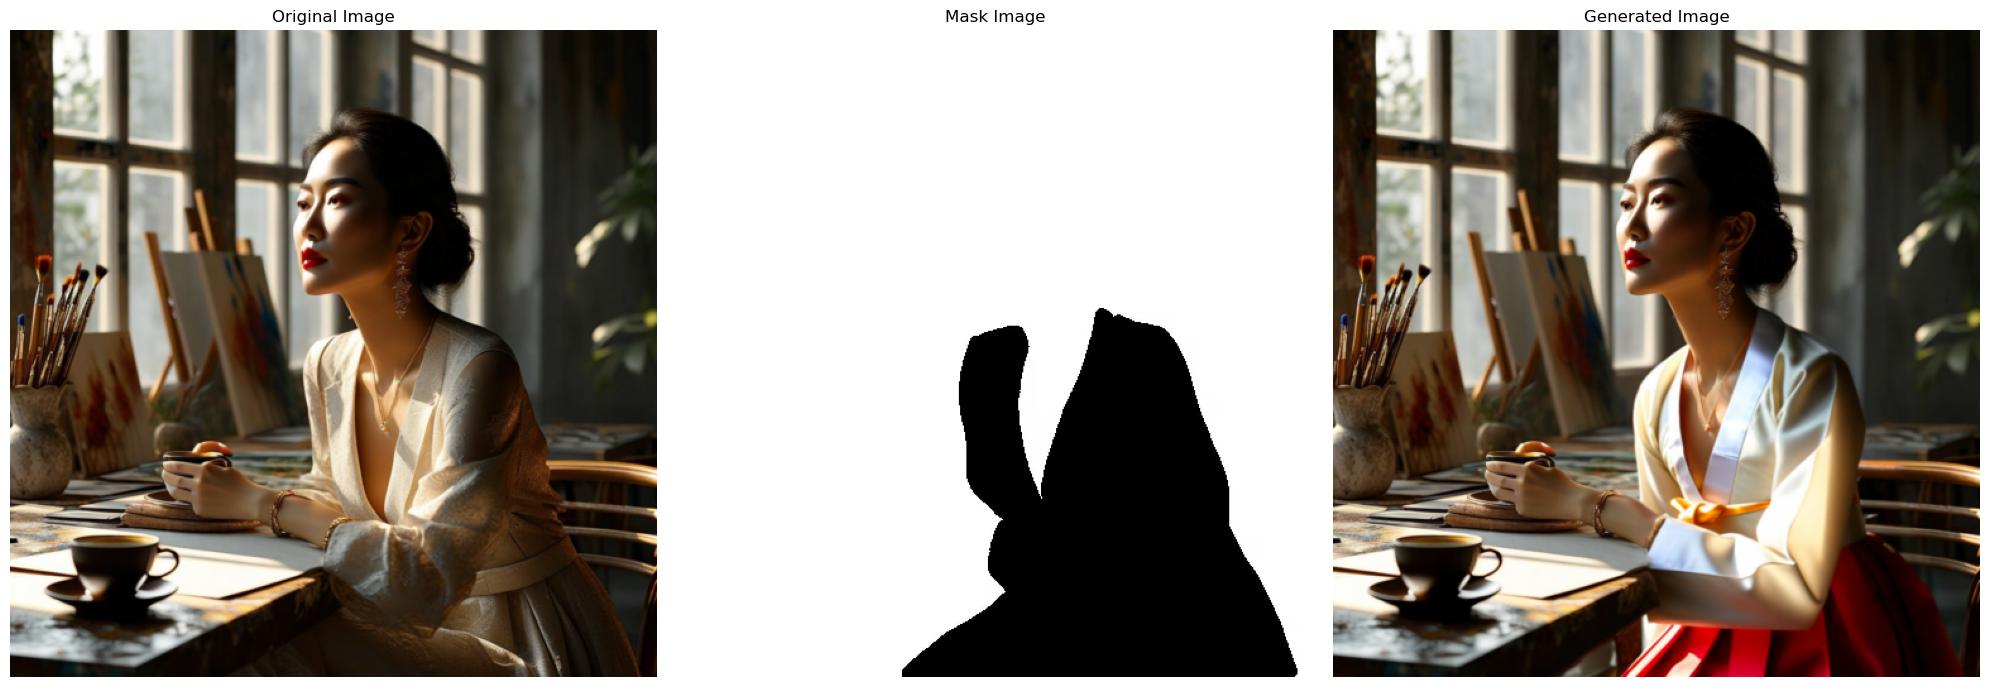

In [18]:
_img_generation_and_show(
    image_generation_model=image_generation_model,
    body=body,
    original_image_path=origin_img_path,
    mask_image_path=mask_img_path
)

### Case 3: 배경 교체 (인물 유지)

- #### Using `inpainting`
    - mask: 바꾸고 싶은 부분이 검은색 

In [19]:
origin_img_path = "./sample_images/GENERATED_IMAGE.png"
origin_img_bytes, origin_img_base64 = _png_to_bytes(origin_img_path)

mask_img_path = "./sample_images/bg_inpaint_masking_image.png"
mask_img_bytes, mask_img_base64 = _png_to_bytes(mask_img_path)

In [20]:
body = json.dumps(
    {
        "taskType": "INPAINTING",
        "inPaintingParams": {
            #"text": "cozy European cafe interior in a quaint village, vintage wooden tables and chairs, soft natural daylight through large windows casting realistic shadows, seamless integration with the subject, atmospheric perspective, rustic stone walls, warm afternoon ambiance, depth of field effect, other cafe patrons quietly chatting in the background sitting at wooden tables, perfect shadow matching and ambient occlusion, cohesive lighting direction from windows, potted plants on windowsills, charming cobblestone street view through windows, consistent color grading, photorealistic rendering, natural edge blending, 8k resolution, cinematic quality, detailed textures, ultra high-resolution 8K output with sharp details",
            "text": "Transform the background into a serene winter landscape, with fresh pristine snow covering the ground and tree branches. Add gentle snowflakes falling in the air, creating a soft, dreamy atmosphere. Maintain the lighting and perspective of the original image while incorporating cool winter tones with hints of blue and silver. The transition between the subject and the winter background should be seamless and natural, preserving the original subject's lighting and shadows",
            "negativeText": "bad quality, low res",
            "image": origin_img_base64,
            "maskImage": mask_img_base64
            #"maskPrompt": "washing machine"
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,
            "height": 512,
            "width": 512,
            "cfgScale": 9.0,
            "seed": 7,
            "quality": "premium" #"standard" | "premium",
        }
    }
)

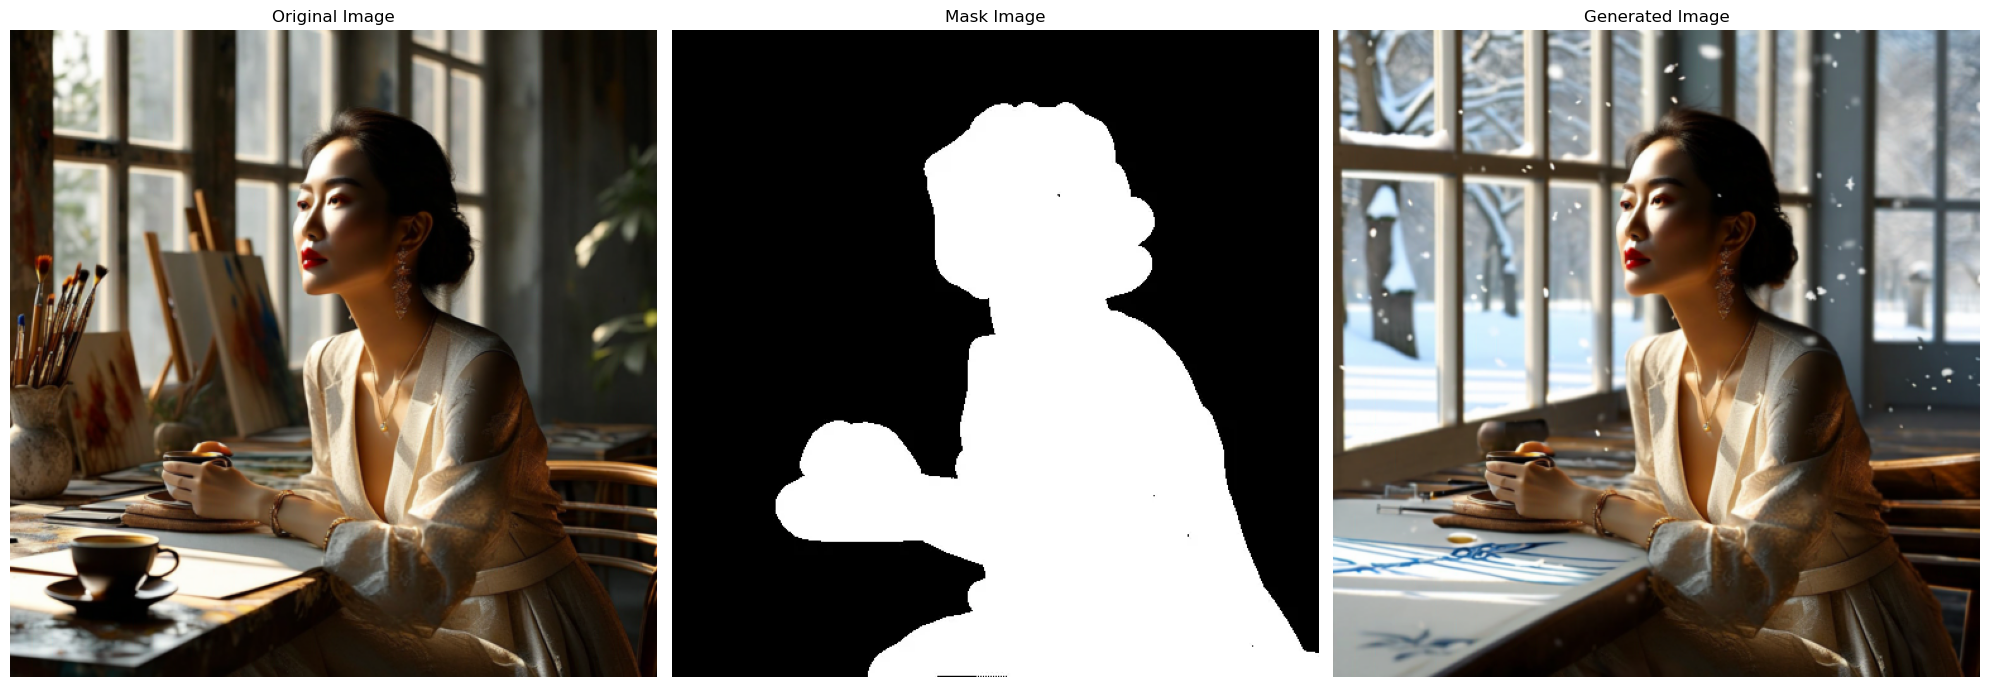

In [21]:
_img_generation_and_show(
    image_generation_model=image_generation_model,
    body=body,
    original_image_path=origin_img_path,
    mask_image_path=mask_img_path
)

- #### Using `outpainting`
  - mask: 바꾸고 싶은 부분이 흰색

In [22]:
origin_img_path = "./sample_images/GENERATED_IMAGE.png"
origin_img_bytes, origin_img_base64 = _png_to_bytes(origin_img_path)

mask_img_path = "./sample_images/bg_outpaint_masking_image_inverse.png"
mask_img_bytes, mask_img_base64 = _png_to_bytes(mask_img_path)

In [23]:
body = json.dumps(
    {
        "taskType": "OUTPAINTING",
        "outPaintingParams": {
            #"text": "cozy European cafe interior in a quaint village, vintage wooden tables and chairs, soft natural daylight through large windows casting realistic shadows, seamless integration with the subject, atmospheric perspective, rustic stone walls, warm afternoon ambiance, depth of field effect, other cafe patrons quietly chatting in the background sitting at wooden tables, perfect shadow matching and ambient occlusion, cohesive lighting direction from windows, potted plants on windowsills, charming cobblestone street view through windows, consistent color grading, photorealistic rendering, natural edge blending, 8k resolution, cinematic quality, detailed textures, ultra high-resolution 8K output with sharp details",
            "text": "Transform the background into a serene winter landscape, with fresh pristine snow covering the ground and tree branches. Add gentle snowflakes falling in the air, creating a soft, dreamy atmosphere. Maintain the lighting and perspective of the original image while incorporating cool winter tones with hints of blue and silver. The transition between the subject and the winter background should be seamless and natural, preserving the original subject's lighting and shadows",
            "negativeText": "bad quality, low resolution, cartoon",
            "image": origin_img_base64,
            #"maskPrompt": "person",
            "maskImage": mask_img_base64,
            "outPaintingMode": "PRECISE",
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,
            "height": 512,
            "width": 512,
            "cfgScale": 8.0,
            "seed": 10, #random.randint(0, 100000)
            "quality": "premium" #"standard" | "premium",
        }
    }
)

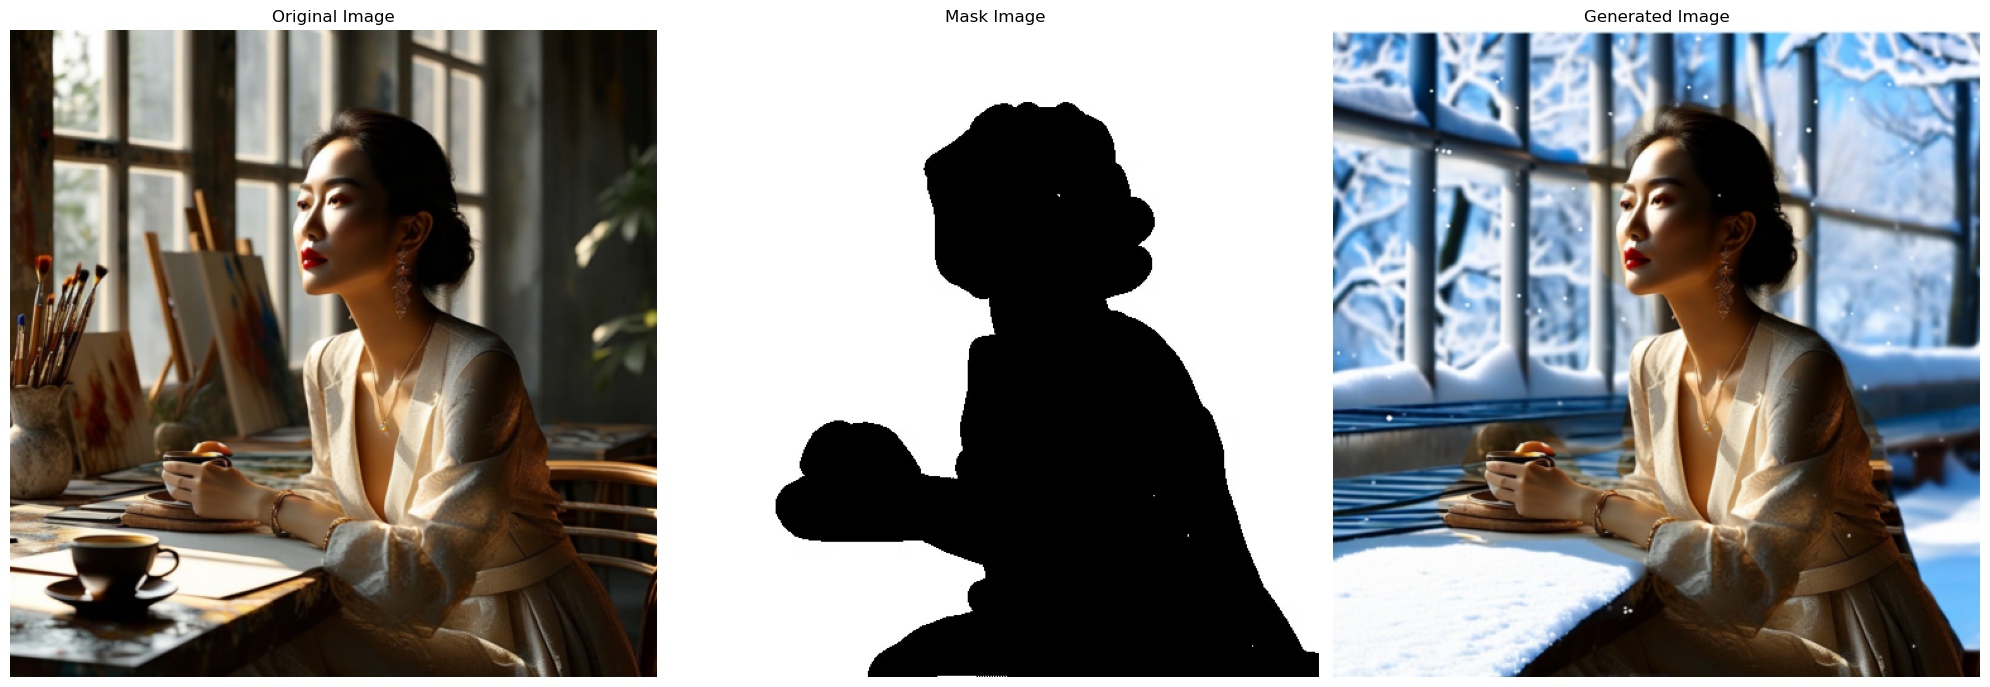

In [24]:
_img_generation_and_show(
    image_generation_model=image_generation_model,
    body=body,
    original_image_path=origin_img_path,
    mask_image_path=mask_img_path
)

### Case 4: 스타일 트랜스퍼 
 - 이미지 스타일 변환 (https://amazon.enterprise.slack.com/archives/C05V607PNJ2/p1737142572971069?thread_ts=1737142572.971069&cid=C05V607PNJ2)

In [25]:
origin_img_path = "./sample_images/GENERATED_IMAGE.png"
origin_img_bytes, origin_img_base64 = _png_to_bytes(origin_img_path)

In [26]:
body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            "text": "Transform the background into a serene winter landscape, with fresh pristine snow covering the ground and tree branches. Add gentle snowflakes falling in the air, creating a soft, dreamy atmosphere. Maintain the lighting and perspective of the original image while incorporating cool winter tones with hints of blue and silver. The transition between the subject and the winter background should be seamless and natural, preserving the original subject's lighting and shadows.",
            "negativeText": "bad quality, low resolution, cartoon",
            "conditionImage": origin_img_base64,
            "controlMode": "SEGMENTATION", # "CANNY_EDGE" | "SEGMENTATION", 
            "controlStrength": 0.8 # 0 to 1.0
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,
            "height": 512,
            "width": 512,
            "cfgScale": 8.0,
            "seed": 8, #random.randint(0, 100000)
            "quality": "premium" #"standard" | "premium",
        }
    }
)

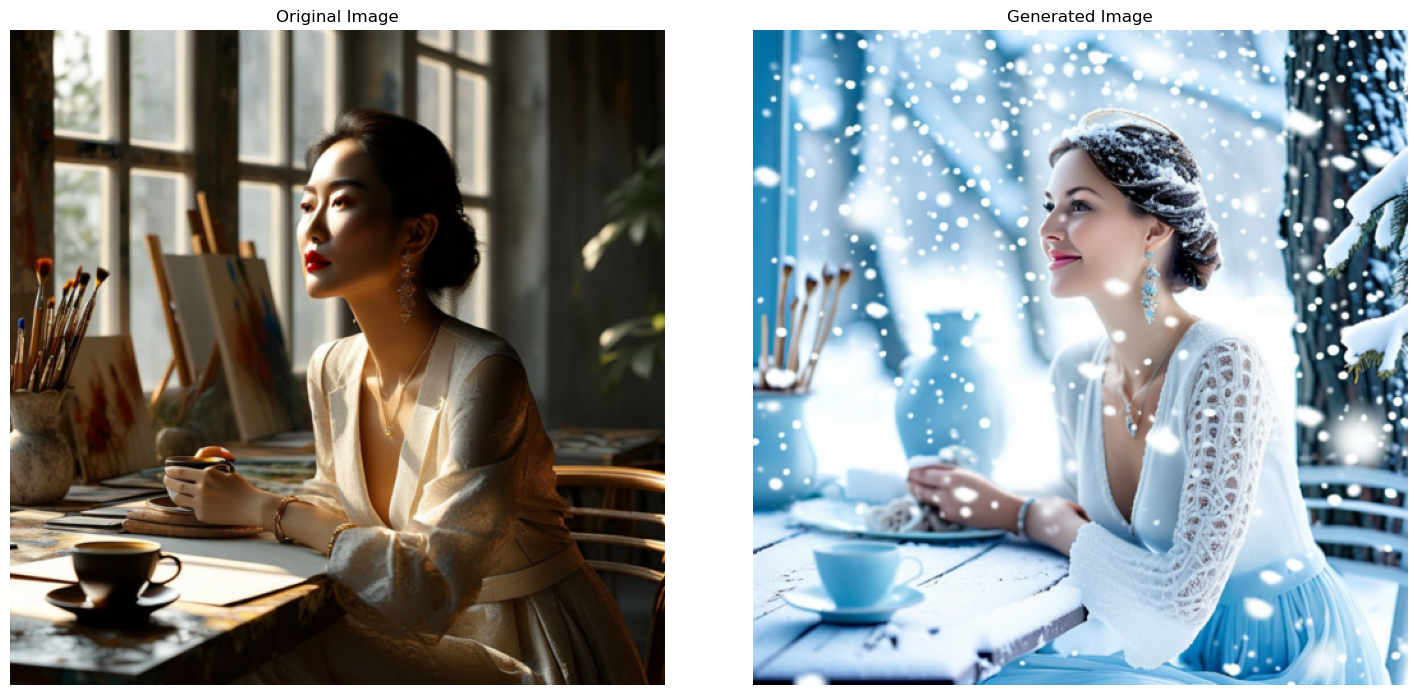

In [27]:
_img_generation_and_show(
    image_generation_model=image_generation_model,
    body=body,
    original_image_path=origin_img_path
)

### Case 5: 아웃 페인팅  (제품 광고 이미지 생성) - 아웃페인팅
- https://amzn-aws.slack.com/archives/C05V607PNJ2/p1737647043066619

In [28]:
import random

In [29]:
origin_img_path = "./sample_images/product.png"
origin_img_bytes, origin_img_base64 = _png_to_bytes(origin_img_path)

mask_img_path = "./sample_images/product_masking_image_inverse.png"
mask_img_bytes, mask_img_base64 = _png_to_bytes(mask_img_path)

In [30]:
body = json.dumps(
    {
        "taskType": "OUTPAINTING",
        "outPaintingParams": {
            "text": "Close-up of an action camera on a tripod partially submerged in powdery snow, with a skier blurred in the background",
            "negativeText": "bad quality, low resolution, cartoon",
            "image": origin_img_base64,
            "maskPrompt": "action camera",
            #"maskImage": mask_img_base64,
            "outPaintingMode": "PRECISE",
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,
            "height": 512,
            "width": 512,
            "cfgScale": 8.0,
            "seed": random.randint(0, 100000)
        }
    }
)

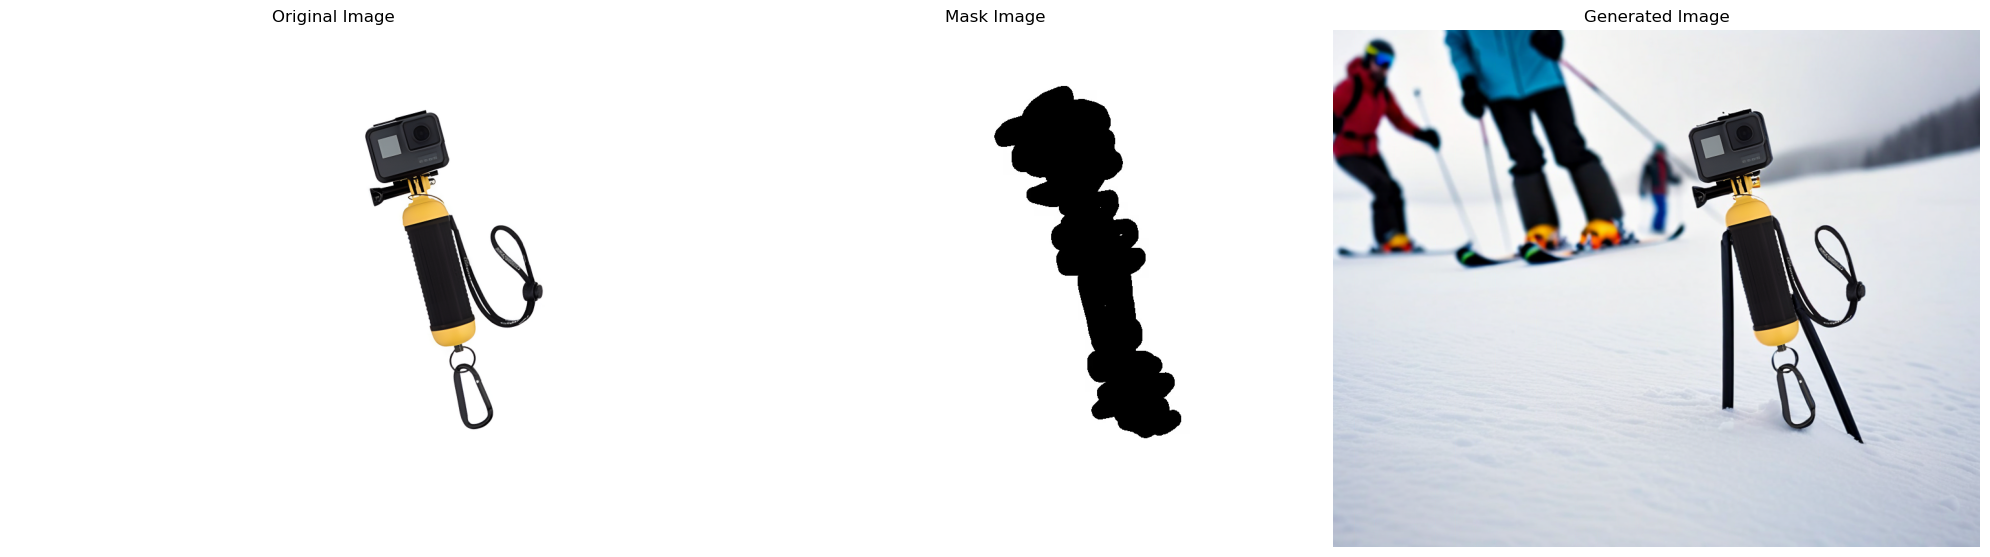

In [31]:
_img_generation_and_show(
    image_generation_model=image_generation_model,
    body=body,
    original_image_path=origin_img_path,
    mask_image_path=mask_img_path
)

### 위 다 되면 프롬프팅을 잘 할 수 있는 에이전트 만들기 